#### Final performance of piecewise approach

- Evaluated on BBOB 2D FIDs {1, 8, 20}, 3 outer seeds
- New inner seed for each run
- Outer: AC Facade, 1000 steps, 5 max evals per config

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from carps.analysis.gather_data import normalize_logs, get_interpolated_performance_df

In [2]:
def load_set(paths: list[str], set_id: str = "unknown") -> tuple[pd.DataFrame, pd.DataFrame]:
    logs = []
    for p in paths:
        fn = Path(p) / "trajectory.parquet"
        if not fn.is_file():
            fn = Path(p) / "runs/logs.csv"
        logs.append(pd.read_csv(fn))

    df = pd.concat(logs).reset_index(drop=True)
    df_cfg = pd.concat([pd.read_csv(Path(p) / "runs/logs_cfg.csv") for p in paths]).reset_index(drop=True)
    df["set"] = set_id
    return df, df_cfg

In [3]:
PATH = '/scratch/hpc-prf-intexml/tklenke/experiment_runs/dacbo_piecewise_longer'
NAME = 'dacboenv'

In [4]:
def create_df():
    run_dirs = [(PATH, NAME)]
    dfs = [load_set(paths=[ps], set_id=set_id) for ps, set_id in run_dirs]

    df = pd.concat([d for d, _ in dfs]).reset_index(drop=True)
    df = normalize_logs(df)

    perf = get_interpolated_performance_df(df)

    perf_time = get_interpolated_performance_df(df, x_column="time_norm")

    perf.to_parquet(f'{PATH}/perf.parquet')
    perf_time.to_parquet(f'{PATH}/perf_time.parquet')

In [14]:
create_df()

[18:49:00] INFO     Start normalization...                                                       ]8;id=76004;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=542160;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#602\602]8;;\

           INFO     Normalize n_trials...                                                        ]8;id=1403;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=256914;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#603\603]8;;\

           INFO     Normalize cost...                                                            ]8;id=34638;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=438621;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#605\605]8;;\

           INFO     Calc normalized incumbent cost...                                            ]8;id=170583;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=673071;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#621\621]8;;\

           INFO     Normalize time...                                                            ]8;id=805828;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=133438;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#641\641]8;;\

           INFO     Done.                                                                        ]8;id=99667;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=2791;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#644\644]8;;\

           INFO     Create dataframe for neat plotting by aligning x-axis / interpolating        ]8;id=532748;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=39889;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#718\718]8;;\
                    budget.                                                                                        

           INFO     Create dataframe for neat plotting by aligning x-axis / interpolating        ]8;id=256956;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=688597;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#718\718]8;;\
                    budget.                                                                                        

In [15]:
# Data loading
df = pd.read_parquet(f'{PATH}/perf.parquet')

In [16]:
final = pd.DataFrame(columns=['optimizer_id', 'task_id', 'incumbent_value', 'seed'])

for problem in df['task_id'].unique():
    filtered = df[df['task_id'] == problem]

    incumbents = filtered.groupby(["optimizer_id", "seed"])["trial_value__cost_inc_norm"].min().reset_index()
    incumbents.columns = ['optimizer_id', 'seed', 'incumbent_value']
    incumbents['task_id'] = problem

    final = pd.concat([final, incumbents], ignore_index=True)

final.to_csv(f'{PATH}/final.csv')

/tmp/ipykernel_4034539/2516198194.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, incumbents], ignore_index=True)


In [17]:
final = pd.read_csv(f'{PATH}/final.csv')

In [19]:
FIGURE_PATH = '../figures'

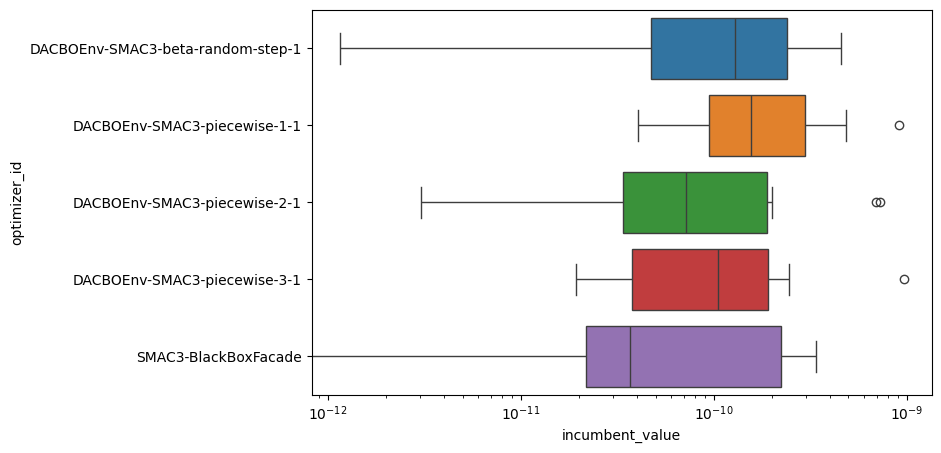

In [18]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=final[final["task_id"].str.endswith("/1/0")], x='incumbent_value', y='optimizer_id', hue='optimizer_id')
plt.xscale('log')
#plt.savefig(f'{FIGURE_PATH}/learned_policies/1.pdf', bbox_inches='tight')
plt.show()

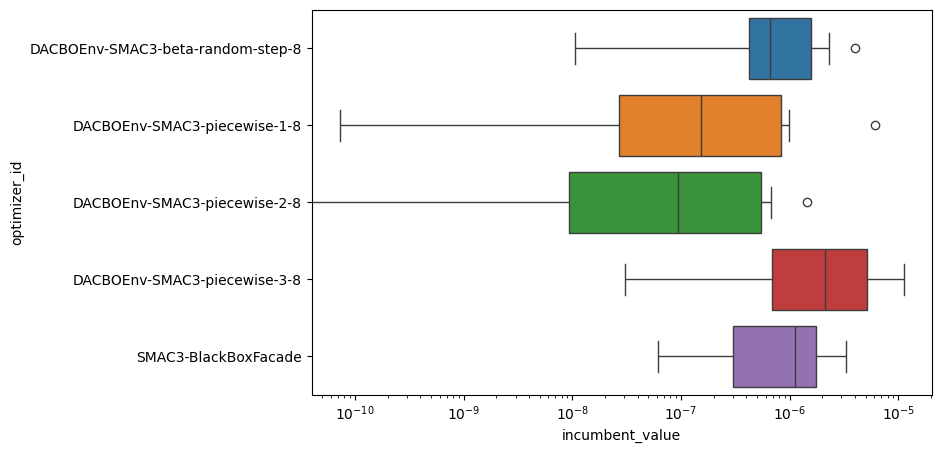

In [19]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=final[final["task_id"].str.endswith("/8/0")], x='incumbent_value', y='optimizer_id', hue='optimizer_id')
plt.xscale('log')
#plt.savefig(f'{FIGURE_PATH}/learned_policies/1.pdf', bbox_inches='tight')
plt.show()

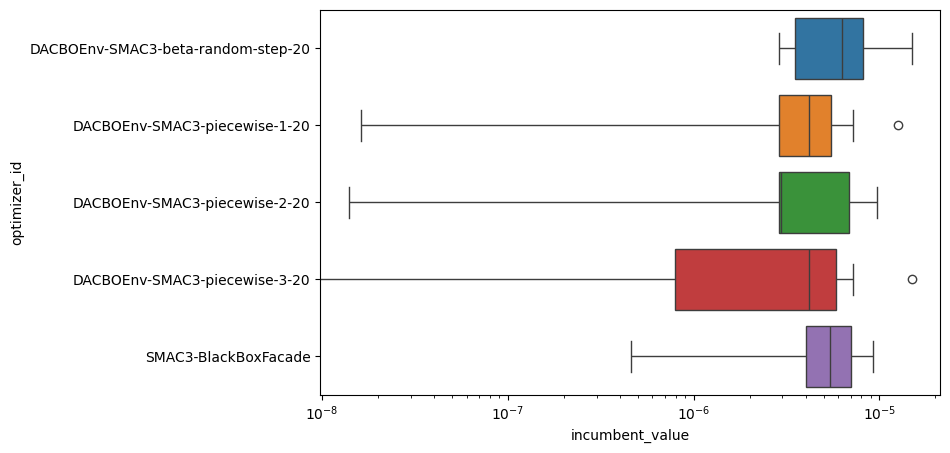

In [20]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=final[final["task_id"].str.endswith("/20/0")], x='incumbent_value', y='optimizer_id', hue='optimizer_id')
plt.xscale('log')
#plt.savefig(f'{FIGURE_PATH}/learned_policies/1.pdf', bbox_inches='tight')
plt.show()

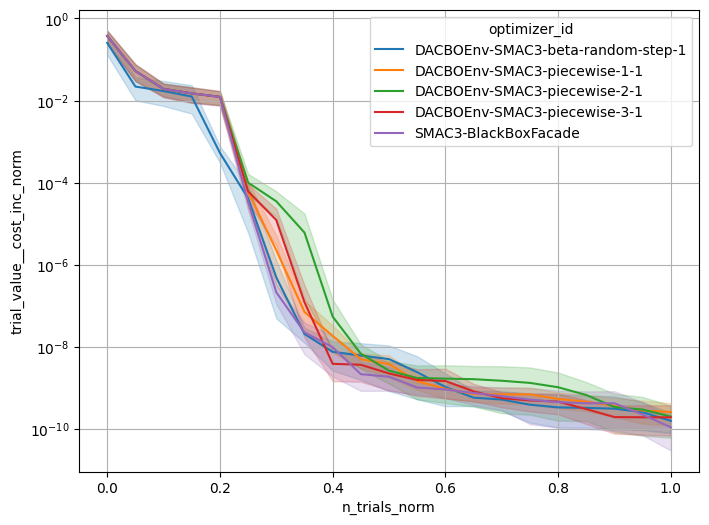

In [21]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/1/0")], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)
#plt.savefig(f'{FIGURE_PATH}/learned_policies/2.pdf', bbox_inches='tight')

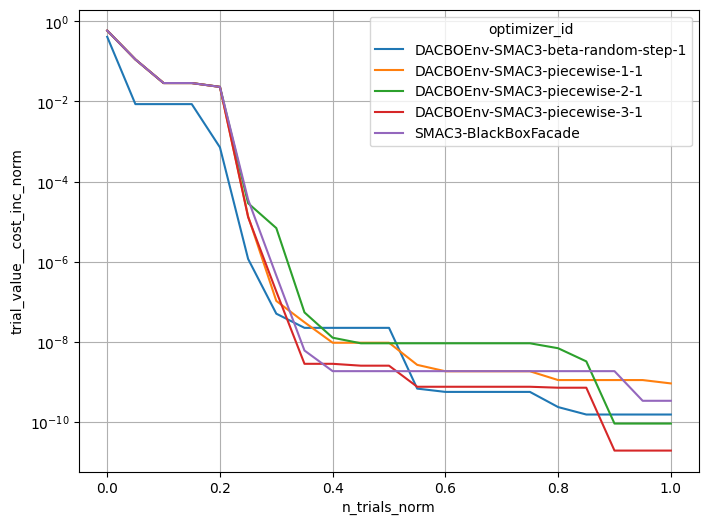

In [22]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/1/0") & (df["seed"] == 1)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

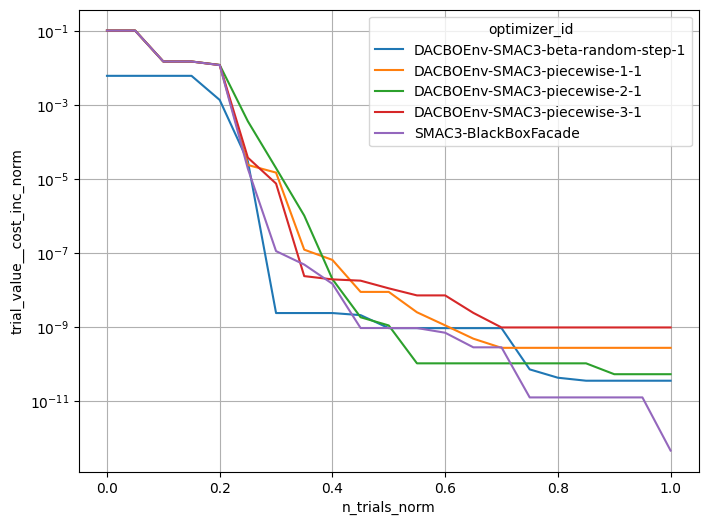

In [23]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/1/0") & (df["seed"] == 2)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

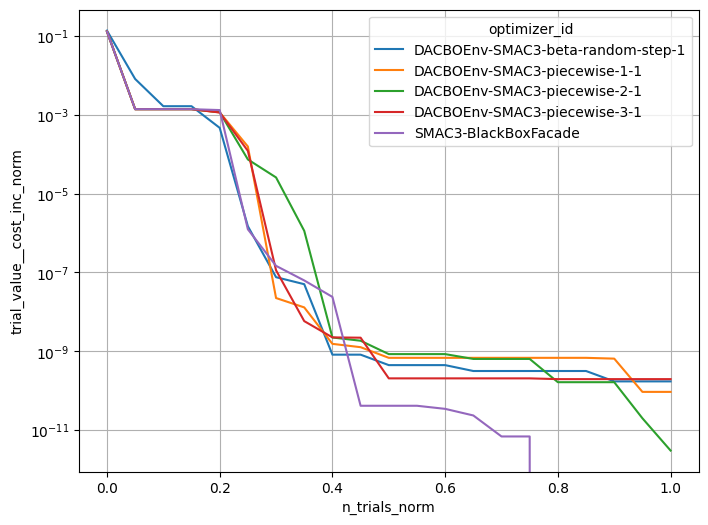

In [24]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/1/0") & (df["seed"] == 3)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

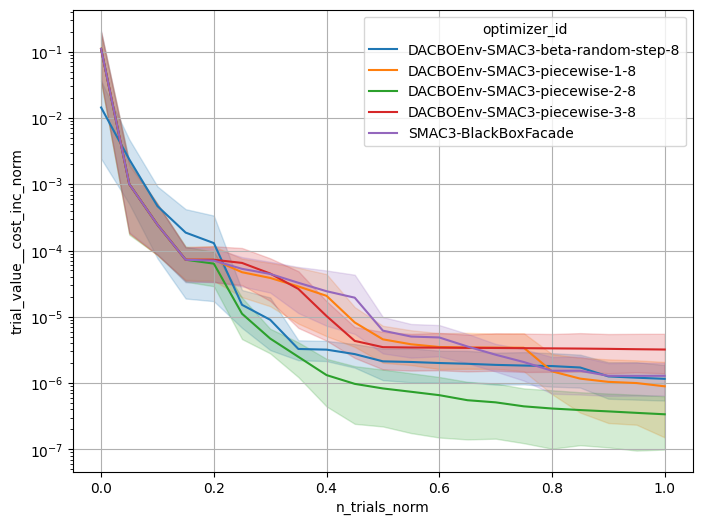

In [25]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/8/0")], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)
#plt.savefig(f'{FIGURE_PATH}/learned_policies/2.pdf', bbox_inches='tight')

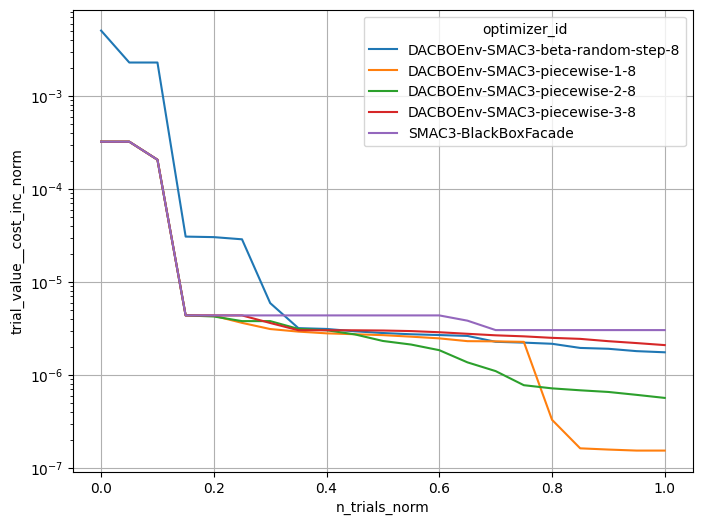

In [26]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/8/0") & (df["seed"] == 1)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

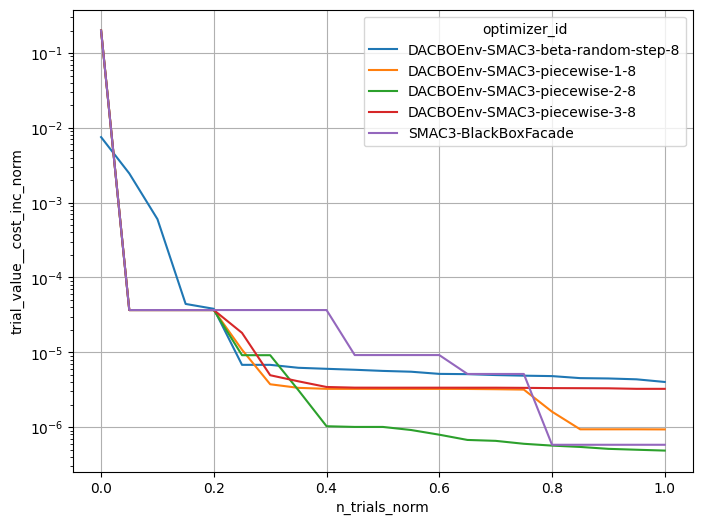

In [27]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/8/0") & (df["seed"] == 2)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

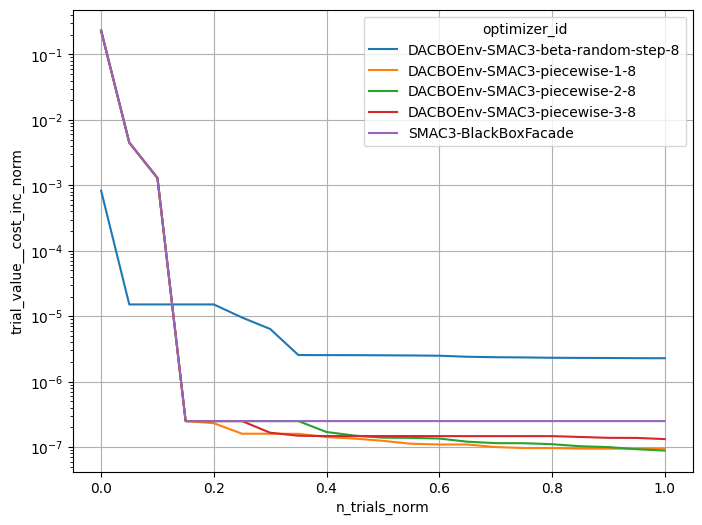

In [28]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/8/0") & (df["seed"] == 3)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

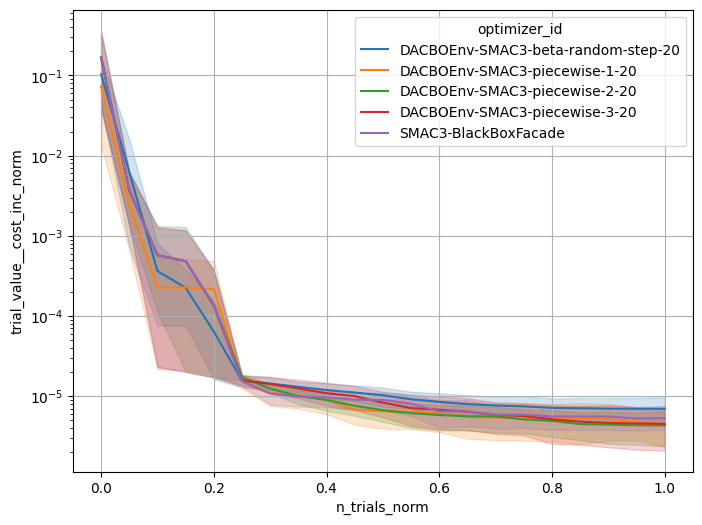

In [29]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/20/0")], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)
#plt.savefig(f'{FIGURE_PATH}/learned_policies/2.pdf', bbox_inches='tight')

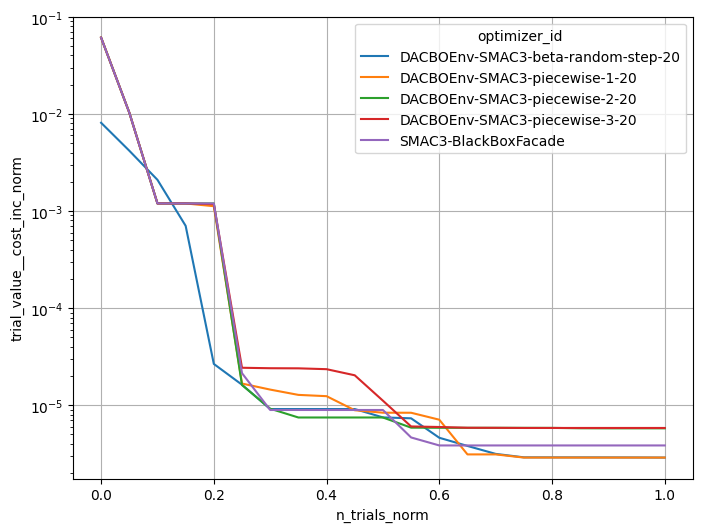

In [30]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/20/0") & (df["seed"] == 1)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)
#plt.savefig(f'{FIGURE_PATH}/learned_policies/2.pdf', bbox_inches='tight')

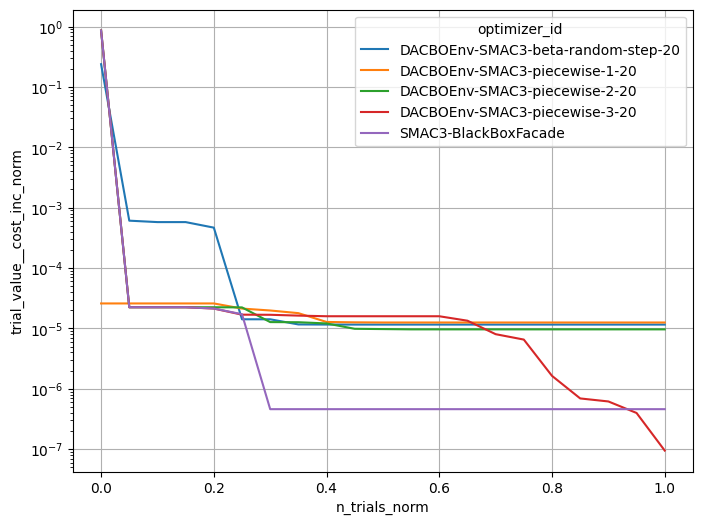

In [31]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/20/0") & (df["seed"] == 2)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)
#plt.savefig(f'{FIGURE_PATH}/learned_policies/2.pdf', bbox_inches='tight')

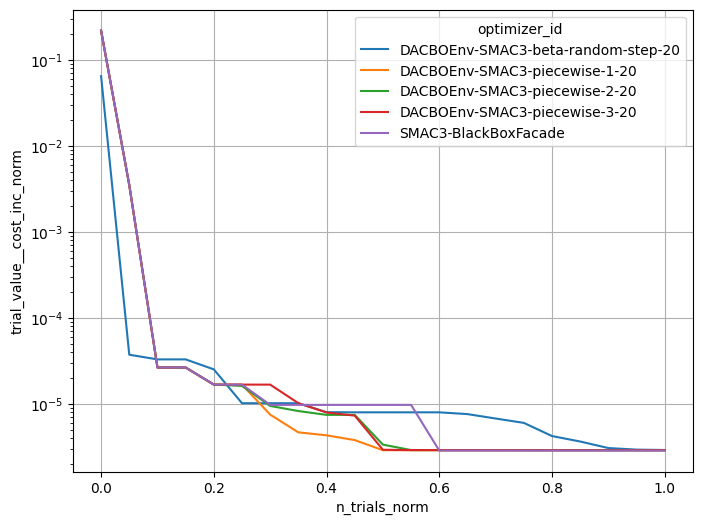

In [32]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/20/0") & (df["seed"] == 3)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)
#plt.savefig(f'{FIGURE_PATH}/learned_policies/2.pdf', bbox_inches='tight')